[View in Colaboratory](https://colab.research.google.com/github/jsedoc/Sharvin-Shah-Spring-2018/blob/master/tree2seq_colab.ipynb)

In [23]:
import sys
print(sys.version_info)

!pip install http://download.pytorch.org/whl/cu90/torch-0.3.0.post4-cp36-cp36m-linux_x86_64.whl
!pip install tqdm nltk
import torch

print(torch.cuda.device_count())
use_cuda = torch.cuda.is_available()
use_cuda = 0

sys.version_info(major=3, minor=6, micro=3, releaselevel='final', serial=0)
1


In [24]:
!rm -r data synth_t2t_data.zip
!wget http://www.seas.upenn.edu/~joao/synth_t2t_data.zip
!unzip synth_t2t_data.zip
!pwd

--2018-05-07 12:35:13--  http://www.seas.upenn.edu/~joao/synth_t2t_data.zip
Resolving www.seas.upenn.edu (www.seas.upenn.edu)... 158.130.68.91, 2607:f470:8:64:5ea5::9
Connecting to www.seas.upenn.edu (www.seas.upenn.edu)|158.130.68.91|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10835 (11K) [application/zip]
Saving to: ‘synth_t2t_data.zip’

synth_t2t_data.zip  100%[===================>]  10.58K  --.-KB/s    in 0s      

2018-05-07 12:35:13 (209 MB/s) - ‘synth_t2t_data.zip’ saved [10835/10835]

Archive:  synth_t2t_data.zip
   creating: data/
  inflating: data/train.orig         
/content


In [0]:
from tqdm import tqdm
from copy import deepcopy

PAD = 0
UNK = 1
BOS = 2
EOS = 3

PAD_WORD = '<blank>'
UNK_WORD = '<unk>'
BOS_WORD = '<s>'
EOS_WORD = '</s>'

MAX_LENGTH = 512


import torch
import torch.utils.data as data

from nltk.tree import Tree

datapath = '/content/data/train.orig'

class Dataset(data.Dataset):

    def __len__(self):
        return self.size

    def read_trees(self, filename):
        with open(filename, 'r') as f:
            trees = [Tree.fromstring(line) for line in tqdm(f.readlines())]
        return trees
    
    def read_seqs(self, filename):
        with open(filename, 'r') as f:
            seqs = [line for line in tqdm(f.readlines())]
        return seqs

In [26]:
dataset = Dataset()
trees = dataset.read_trees('/content/data/train.orig')
# print(trees[1])
# print(len(trees))

100%|██████████| 1000/1000 [00:00<00:00, 22978.84it/s]


In [0]:
# creating a dictionary of unique tokens with the assigned id with file input
def create_vocab(filename):
    vocab = dict()
    with open(filename, 'r') as f:
        for token in f.read().split():
            if token not in vocab:
                vocab[token] = 1
            else:
                vocab[token] += 1
    # print(len(vocab.keys()))    
    index = 0
    token_dict = {}            
    for token in vocab.keys():
        token_dict[token] = index
        index += 1
    
    return token_dict

# fetch id of a token from the dictionary  
def fetch_unique_index(token_dict, token):
    return token_dict[token]

# use dictionary of tokens to form a corresponding one hot representation  
def create_one_hot(token_dict):
    one_hot_dict = {}
    vector_dim = len(token_dict.keys())
    for token in token_dict:    
        tensor = torch.zeros(1, vector_dim)
        tensor = tensor.cuda() if use_cuda else tensor
        tensor[0][token_dict[token]] = 1
        one_hot_dict[token] = tensor
    
    return one_hot_dict

# fetch one hot representation for the token
def fetch_one_hot(one_hot_dict, token):
    return one_hot_dict[token]

In [0]:
vocab = create_vocab(datapath)
# print(vocab)
oh_vocab = create_one_hot(vocab)
# print(fetch_one_hot(oh_vocab, '4'))

In [29]:
dataset = Dataset()
trees = dataset.read_trees(datapath)
seqs = dataset.read_seqs(datapath)
print("\n")
print(trees[0])
print(len(trees[0]))
print(seqs[0]) # maybe the seqs has to be split token wise while training
print(len(seqs[0].split()))

100%|██████████| 1000/1000 [00:00<00:00, 656282.90it/s]



(+ 43 47)
2
( + 43 47 )

5


In [0]:
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable as Var

PAD = 0
UNK = 1
BOS = 2
EOS = 3

PAD_WORD = '<blank>'
UNK_WORD = '<unk>'
BOS_WORD = '<s>'
EOS_WORD = '</s>'

# module for childsumtreelstm
class ChildSumTreeLSTM(nn.Module):
    def __init__(self, in_dim, mem_dim):
        super(ChildSumTreeLSTM, self).__init__()
        self.in_dim = in_dim
        self.mem_dim = mem_dim
        self.ioux = nn.Linear(self.in_dim, 3 * self.mem_dim)
        self.iouh = nn.Linear(self.mem_dim, 3 * self.mem_dim)
        self.fx = nn.Linear(self.in_dim, self.mem_dim)
        self.fh = nn.Linear(self.mem_dim, self.mem_dim)

    def node_forward(self, inputs, child_c, child_h):
        child_h_sum = torch.sum(child_h, dim=0, keepdim=True)
        # print("dimension of inputs: ", inputs.size())
        # print("dimension of child_h_sum: ", child_h_sum.size())
        iou = self.ioux(inputs) + self.iouh(child_h_sum)
        i, o, u = torch.split(iou, iou.size(1) // 3, dim=1)
        i, o, u = F.sigmoid(i), F.sigmoid(o), F.tanh(u)

        f = F.sigmoid(
            self.fh(child_h) +
            self.fx(inputs).repeat(len(child_h), 1)
        )
        fc = torch.mul(f, child_c)

        c = torch.mul(i, u) + torch.sum(fc, dim=0, keepdim=True)
        h = torch.mul(o, F.tanh(c))
        return c, h

    def forward(self, tree):
      # print(type(tree))
      # print(tree)
      if type(tree) == Tree:
        child_states = []
        for child in tree:
            child_states.append(self.forward(child))
        child_c, child_h = zip(* map(lambda x: x, child_states))
        child_c, child_h = torch.cat(child_c, dim=0), torch.cat(child_h, dim=0)

        if type(tree) == str:
          node_label_repr = Var(fetch_one_hot(oh_vocab, tree))
        else:
          node_label_repr = Var(fetch_one_hot(oh_vocab, tree.label()))
        state = self.node_forward(node_label_repr, child_c, child_h)
      else:
        # print(type(tree))
        if type(tree) == str:
          node_label_repr = Var(fetch_one_hot(oh_vocab, tree))
        child_c = Var(node_label_repr.data.new(1, self.mem_dim).fill_(0.))
        child_h = Var(node_label_repr.data.new(1, self.mem_dim).fill_(0.))
        state = self.node_forward(node_label_repr, child_c, child_h)
      # Using tree.label() instead of torch.zeros() ensures that the device placement is inherited  

      return state



# module for distance-angle similarity
class Similarity(nn.Module):
  def __init__(self, mem_dim, hidden_dim, num_classes):
    super(Similarity, self).__init__()
    self.mem_dim = mem_dim
    self.hidden_dim = hidden_dim
    self.num_classes = num_classes
    self.wh = nn.Linear(2 * self.mem_dim, self.hidden_dim)
    self.wp = nn.Linear(self.hidden_dim, self.num_classes)

  def forward(self, lvec, rvec):
    mult_dist = torch.mul(lvec, rvec)
    abs_dist = torch.abs(torch.add(lvec, -rvec))
    vec_dist = torch.cat((mult_dist, abs_dist), 1)

    out = F.sigmoid(self.wh(vec_dist))
    out = F.log_softmax(self.wp(out), dim=1)
    return out


# putting the whole model together
class SimilarityTreeLSTM(nn.Module):
    def __init__(self, vocab_size, in_dim, mem_dim, hidden_dim, num_classes, sparsity, freeze):
        super(SimilarityTreeLSTM, self).__init__()
        self.emb = nn.Embedding(vocab_size, in_dim, padding_idx=PAD, sparse=sparsity)
        if freeze:
            self.emb.weight.requires_grad = False
        self.childsumtreelstm = ChildSumTreeLSTM(in_dim, mem_dim)
        self.similarity = Similarity(mem_dim, hidden_dim, num_classes)

    def forward(self, ltree, linputs, rtree, rinputs):
        linputs = self.emb(linputs)
        rinputs = self.emb(rinputs)
        lstate, lhidden = self.childsumtreelstm(ltree, linputs)
        rstate, rhidden = self.childsumtreelstm(rtree, rinputs)
        output = self.similarity(lstate, rstate)
        return output

In [31]:
# encoder input size (in_dim) could be anything
# encoder hidden size (mem_dim) would be equal to the dimension of the vector
# encoder hidden size could be anything, decoder hidden size is dependent on final encoder hidden state size
# decoder output size could be anything
cs_treelstm = ChildSumTreeLSTM(71, 128)
print(cs_treelstm)
out = cs_treelstm.forward(trees[1])

ChildSumTreeLSTM(
  (ioux): Linear(in_features=71, out_features=384)
  (iouh): Linear(in_features=128, out_features=384)
  (fx): Linear(in_features=71, out_features=128)
  (fh): Linear(in_features=128, out_features=128)
)


In [32]:
out
out[1]

Variable containing:

Columns 0 to 9 
-0.0007 -0.0674 -0.1162 -0.0266  0.0215  0.0107 -0.0371  0.0220  0.1811  0.0530

Columns 10 to 19 
-0.0315  0.0061 -0.0682 -0.0706  0.0855  0.0535  0.1400  0.0276 -0.0815 -0.0548

Columns 20 to 29 
 0.2035  0.0177  0.0276 -0.1953 -0.0411  0.0988  0.0322 -0.0148  0.0975 -0.0364

Columns 30 to 39 
-0.0856  0.0181 -0.0616 -0.0587  0.1187  0.0608  0.0381  0.0789 -0.1101  0.0054

Columns 40 to 49 
-0.1654  0.0017  0.1217  0.1327 -0.1534 -0.0424 -0.0092  0.0406 -0.1436  0.0067

Columns 50 to 59 
 0.0478 -0.0813  0.0155 -0.0890  0.0641 -0.1421 -0.1048 -0.0156  0.0659 -0.0477

Columns 60 to 69 
-0.1494  0.0895  0.1048  0.0137  0.0031 -0.0617 -0.0683 -0.0755 -0.0103  0.0725

Columns 70 to 79 
-0.0941  0.0405 -0.0863  0.0093 -0.1355  0.1311  0.1293  0.0259 -0.0817  0.0725

Columns 80 to 89 
 0.0994 -0.1737  0.0256 -0.1912 -0.0329  0.0321 -0.0578 -0.0965 -0.1864  0.1992

Columns 90 to 99 
 0.0932  0.0368  0.1369 -0.2013 -0.0214  0.1536 -0.0308  0.0300 -0.0148

In [0]:
from copy import deepcopy

In [0]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax()

    def forward(self, input, hidden):
        # print("input size: ", input.size())
        # print("input: ", input)
        # print("hidden size: ", hidden.size())
        output = self.embedding(input).view(1, 1, -1)
        # print("After Embedding, size: ", output.size())
        output = F.relu(output)
        # print("output size after ReLU: ", output.size())
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        result = Variable(torch.zeros(1, 1, self.hidden_size))
        if use_cuda:
            return result.cuda()
        else:
            return result

In [0]:
def token_to_index(token_dict, filename):
    file_embedding = []
    
    with open(filename, 'r') as f:
        for line in f.readlines()[:2]:
            line_embedding = []
            print("line: ", line)
            tokens = line.split()
            print("tokens: ", tokens)
            for token in tokens:
                line_embedding.append(token_dict[token])
            
            # print("line embedding: ", line_embedding)
            line_tensor = Var(torch.LongTensor(line_embedding).view(-1, 1))
            # print("line tensor: ", line_tensor)
            file_embedding.append(line_tensor)
            # print("file embedding so far: ", file_embedding)
    
    return file_embedding
  
def index_to_token(token_dict, index):
  flipped = {v:k for k,v in token_dict.items()}
  return flipped[index]

In [36]:
token_embedding = token_to_index(vocab, datapath)
token_embedding[1]

line:  ( + 43 47 )

tokens:  ['(', '+', '43', '47', ')']
line:  ( * ( * ( + 55 ( + 56 53 ) ) 31 ) ( - 5 ( * 54 9 ) ) )

tokens:  ['(', '*', '(', '*', '(', '+', '55', '(', '+', '56', '53', ')', ')', '31', ')', '(', '-', '5', '(', '*', '54', '9', ')', ')', ')']


Variable containing:
    0
    5
    0
    5
    0
    1
    6
    0
    1
    7
    8
    4
    4
    9
    4
    0
   10
   11
    0
    5
   12
   13
    4
    4
    4
[torch.LongTensor of size 25x1]

In [37]:
out[1].size()

torch.Size([1, 128])

In [38]:
len(vocab.keys())


71

In [108]:
decoder = DecoderRNN(out[1].size()[1], len(vocab.keys()))
#hidden = decoder.initHidden()
encoder_outputs = out[1]
encoder_outputs = encoder_outputs.unsqueeze(0)
print(encoder_outputs)
for i in range(out[1].size()[1]):
  out, hidden = decoder.forward(token_embedding[1][i], encoder_outputs)

Variable containing:
( 0 ,.,.) = 

Columns 0 to 8 
   0.0830  0.1689  0.0318 -0.1397 -0.0038 -0.0706  0.0213  0.1614 -0.0587

Columns 9 to 17 
  -0.0931  0.0548  0.0766  0.0468  0.0732 -0.0166  0.0309  0.0661 -0.0907

Columns 18 to 26 
   0.0006 -0.0379 -0.1335 -0.1030 -0.1117 -0.0504  0.0564 -0.0604  0.1586

Columns 27 to 35 
   0.0926  0.0237 -0.1079  0.0186  0.0479  0.0664  0.0132  0.0110  0.0554

Columns 36 to 44 
   0.1098  0.0624  0.0983  0.0368  0.0834  0.1237 -0.0494 -0.0429 -0.0051

Columns 45 to 53 
   0.0684  0.0694  0.0025  0.0160  0.0037  0.0386  0.1678 -0.1381  0.0187

Columns 54 to 62 
   0.1585 -0.0172 -0.1612 -0.0808 -0.0173  0.1391 -0.0667 -0.0873 -0.0309

Columns 63 to 71 
   0.1710  0.0919 -0.0500  0.0971  0.0791  0.0108 -0.0330  0.1698 -0.1184

Columns 72 to 80 
   0.1106  0.0485 -0.0872  0.1201 -0.0327 -0.0448  0.1455 -0.0534 -0.0267

Columns 81 to 89 
   0.1757  0.0633  0.0261  0.0735 -0.1394  0.0106  0.0349 -0.0490  0.0656

Columns 90 to 98 
  -0.0044 -0.0799  0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


IndexError: ignored

In [39]:
out

(Variable containing:
 
 Columns 0 to 9 
 -0.0013 -0.1341 -0.2221 -0.0601  0.0418  0.0204 -0.0787  0.0437  0.3678  0.1020
 
 Columns 10 to 19 
 -0.0558  0.0117 -0.1441 -0.1220  0.1700  0.1124  0.3064  0.0553 -0.1546 -0.1030
 
 Columns 20 to 29 
  0.3921  0.0359  0.0555 -0.3786 -0.0777  0.1885  0.0664 -0.0327  0.2040 -0.0780
 
 Columns 30 to 39 
 -0.1562  0.0346 -0.1108 -0.1268  0.2448  0.1181  0.0804  0.1526 -0.2560  0.0107
 
 Columns 40 to 49 
 -0.3094  0.0034  0.2751  0.2638 -0.3078 -0.0813 -0.0189  0.0776 -0.2939  0.0133
 
 Columns 50 to 59 
  0.0983 -0.1604  0.0291 -0.2024  0.1333 -0.3192 -0.2223 -0.0325  0.1245 -0.0923
 
 Columns 60 to 69 
 -0.3143  0.1869  0.2185  0.0245  0.0063 -0.1181 -0.1625 -0.1489 -0.0201  0.1304
 
 Columns 70 to 79 
 -0.1955  0.0813 -0.1902  0.0180 -0.2948  0.2643  0.2317  0.0508 -0.1699  0.1319
 
 Columns 80 to 89 
  0.1997 -0.3601  0.0480 -0.3985 -0.0685  0.0619 -0.1110 -0.2283 -0.3556  0.3769
 
 Columns 90 to 99 
  0.1777  0.0695  0.2925 -0.4131 -0.0409 

In [0]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [0]:
from torch import optim

tree_variable = trees
target_variable = token_embedding

input_size = len(vocab.keys()) # here also equal to length of output vocab
hidden_size = 128 # any size can be given here
output_size = input_size

encoder = ChildSumTreeLSTM(input_size, hidden_size)
decoder = DecoderRNN(hidden_size, output_size)

if use_cuda:
  encoder = encoder.cuda()
  decoder = decoder.cuda()

learning_rate = 0.0005
encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)

criterion = nn.NLLLoss()

MAX_LENGTH = max([len(i) for i in seqs])

# only one example at a time, needs to be called in an iterative fashion
def train(tree_variable, target_variable, 
          encoder, decoder, encoder_optimizer, decoder_optimizer, 
          criterion, max_length=MAX_LENGTH):
  encoder_optimizer.zero_grad()
  decoder_optimizer.zero_grad()
  # print("tree variable: ", tree_variable)
  # print("target variable: ", target_variable)
  input_length = len(tree_variable)
  # print("input_length: ", input_length)
  target_length = len(target_variable)
  # print("target_length: ", target_length)
  encoder_outputs = Var(torch.zeros(max_length, encoder.mem_dim))
  encoder_outputs = encoder_outputs.cuda() if use_cuda else encoder_outputs
  
  loss = 0

  predicted = []
  
  # encode tree
  # print("Encoding begins......")
  #for ei in range(input_length):
    # print("input variable ei size: ", len(input_variable[ei]))
#   encoder_states = encoder(input_variable[ei])
#   encoder_outputs[ei] = encoder_states[0]
  encoder_states = encoder(input_variable)
  encoder_outputs = encoder_states[0]
    
  # decoder serial and accumulate loss

  decoder_input = Var(torch.LongTensor([[0]]))
  decoder_input = decoder_input.cuda() if use_cuda else decoder_input  
  # print("decoder input: ", decoder_input)
  decoder_hidden = encoder_states[1]
  # print("before unsqueeze: ", decoder_hidden.size())
  decoder_hidden = decoder_hidden.unsqueeze(0)
  # print("after unsqueeze: ", decoder_hidden.size())
  use_teacher_forcing = True 

  if use_teacher_forcing:
    # print("Decoding begins...")
    # Teacher forcing: Feed the target as the next input
    for di in range(target_length):
      decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)
      target_var = Var(torch.LongTensor([[fetch_unique_index(vocab, target_variable[di])]]))
      target_var = target_var.cuda() if use_cuda else target_var
      # print("variable: ", target_var)
      # print("current element: ", target_variable[di])
      # current_target = Var(fetch_one_hot(oh_vocab, target_variable[di]))
      # target_variable[di] = token_embedding[di]
      # print("one hot representation: ", current_target)
      #import pdb;pdb.set_trace()
      loss += criterion(decoder_output, target_var[0][0])
      topv, topi = decoder_output.data.topk(1)
      ni = topi[0][0]
      predicted.append(ni)
      decoder_input = target_var  # Teacher forcing

  # call backward

  loss.backward()

  # update parameters
  
  encoder_optimizer.step()
  decoder_optimizer.step()

  return (loss.data[0] / target_length, predicted)


In [42]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
  plt.figure()
  fig, ax = plt.subplots()
  # this locator puts ticks at regular intervals
  loc = ticker.MultipleLocator(base=0.2)
  ax.yaxis.set_major_locator(loc)
  plt.plot(points)

print_every = 100
plot_every = 100
start = time.time()
plot_losses = []
print_loss_total = 0  # Reset every print_every
plot_loss_total = 0  # Reset every plot_every
n_iters = 100

iteration_count = 0

for k in range(n_iters):
  for i in range(len(trees)):
    iteration_count += 1
    input_variable = trees[i]

    target_variable = seqs[i].split()

    loss, predicted = train(input_variable, target_variable, encoder,
                            decoder, encoder_optimizer, decoder_optimizer, criterion)
    print_loss_total += loss
    plot_loss_total += loss

    if (i+1) % print_every == 0:
      print('input: ', trees[i])
      print('target: ', seqs[i][:-1])
      print('pred: ', " ".join([index_to_token(vocab, x) for x in predicted]))
      print_loss_avg = print_loss_total / print_every
      print_loss_total = 0
      print('iterations: %d, time elapsed: %s, loss:%.4f' % (iteration_count, timeSince(start, i / (n_iters)),
                                     print_loss_avg))

    if (i+1) % plot_every == 0:
      plot_loss_avg = plot_loss_total / plot_every
      plot_losses.append(plot_loss_avg)
      print(len(plot_losses))
      plot_loss_total = 0  

#showPlot(plot_losses)      

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


input:  (+ 28 53)
target:  ( + 28 53 )
pred:  ( ( ( ) )
iterations: 100, time elapsed: 0m 2s (- 0m 0s), loss:3.1359
1
input:  (* (+ (* (/ 61 56) 60) (- 49 59)) (- (- 58 16) 35))
target:  ( * ( + ( * ( / 61 56 ) 60 ) ( - 49 59 ) ) ( - ( - 58 16 ) 35 ) )
pred:  ( ( ( + ( + ( + ( ( ) ) ) ) + ( ) ) ) ) + ( + ( ) ) ) ) )
iterations: 200, time elapsed: 0m 5s (- -1m 57s), loss:2.4798
2
input:  (/ (- 21 61) (+ 58 (* (- 1 60) 59)))
target:  ( / ( - 21 61 ) ( + 58 ( * ( - 1 60 ) 59 ) ) )
pred:  ( + ( + ( ( ) ( + ( ( + ( + ( ( ) ) ) ) )
iterations: 300, time elapsed: 0m 8s (- -1m 54s), loss:2.1830
3
input:  (* 44 (/ (* (* 46 28) 45) 43))
target:  ( * 44 ( / ( * ( * 46 28 ) 45 ) 43 ) )
pred:  ( * ( ( + ( + ( + ( ( ) ) ) ) ) )
iterations: 400, time elapsed: 0m 11s (- -1m 51s), loss:2.0207
4
input:  (+ 20 (/ 44 33))
target:  ( + 20 ( / 44 33 ) )
pred:  ( - ( ( * 60 57 ) )
iterations: 500, time elapsed: 0m 14s (- -1m 48s), loss:1.9375
5
input:  (- 27 26)
target:  ( - 27 26 )
pred:  ( + 59 60 )
iterat

input:  (* (+ (* (/ 61 56) 60) (- 49 59)) (- (- 58 16) 35))
target:  ( * ( + ( * ( / 61 56 ) 60 ) ( - 49 59 ) ) ( - ( - 58 16 ) 35 ) )
pred:  ( * ( * ( * ( * 62 60 ) 60 ) ( + 59 ( ) ) ( + ( - 59 59 ) ( ) )
iterations: 3200, time elapsed: 1m 36s (- -1m 12s), loss:1.6943
32
input:  (/ (- 21 61) (+ 58 (* (- 1 60) 59)))
target:  ( / ( - 21 61 ) ( + 58 ( * ( - 1 60 ) 59 ) ) )
pred:  ( / ( - ( ( ) ( + ( ( + ( / 59 61 ) 59 ) ) )
iterations: 3300, time elapsed: 1m 38s (- -2m 54s), loss:1.6815
33
input:  (* 44 (/ (* (* 46 28) 45) 43))
target:  ( * 44 ( / ( * ( * 46 28 ) 45 ) 43 ) )
pred:  ( * ( ( * ( * ( * 52 55 ) 56 ) ( ) )
iterations: 3400, time elapsed: 1m 41s (- -2m 43s), loss:1.6887
34
input:  (+ 20 (/ 44 33))
target:  ( + 20 ( / 44 33 ) )
pred:  ( * ( ( * ( ( ) )
iterations: 3500, time elapsed: 1m 44s (- -2m 36s), loss:1.6350
35
input:  (- 27 26)
target:  ( - 27 26 )
pred:  ( - 53 54 )
iterations: 3600, time elapsed: 1m 47s (- -2m 30s), loss:1.6223
36
input:  (/ (* 61 (* 62 (* 63 17))) (-

input:  (/ (- 21 61) (+ 58 (* (- 1 60) 59)))
target:  ( / ( - 21 61 ) ( + 58 ( * ( - 1 60 ) 59 ) ) )
pred:  ( - ( - ( 61 ) ( * ( ( * ( - 61 61 ) 59 ) ) )
iterations: 6300, time elapsed: 3m 8s (- -3m 54s), loss:1.3463
63
input:  (* 44 (/ (* (* 46 28) 45) 43))
target:  ( * 44 ( / ( * ( * 46 28 ) 45 ) 43 ) )
pred:  ( * ( ( * ( * ( / 25 45 ) 45 ) ( ) )
iterations: 6400, time elapsed: 3m 11s (- -3m 36s), loss:1.3653
64
input:  (+ 20 (/ 44 33))
target:  ( + 20 ( / 44 33 ) )
pred:  ( + ( ( / 46 45 ) )
iterations: 6500, time elapsed: 3m 14s (- -3m 24s), loss:1.3445
65
input:  (- 27 26)
target:  ( - 27 26 )
pred:  ( - 53 26 )
iterations: 6600, time elapsed: 3m 17s (- -3m 15s), loss:1.3178
66
input:  (/ (* 61 (* 62 (* 63 17))) (- (* 60 50) 59))
target:  ( / ( * 61 ( * 62 ( * 63 17 ) ) ) ( - ( * 60 50 ) 59 ) )
pred:  ( / ( * ( ( * 62 ( * 61 61 ) ) ) ( * ( * 60 59 ) 59 ) )
iterations: 6700, time elapsed: 3m 20s (- -3m 7s), loss:1.3010
67
input:  (* (* 45 (+ 59 57)) (/ 7 58))
target:  ( * ( * 45 ( 

input:  (* 44 (/ (* (* 46 28) 45) 43))
target:  ( * 44 ( / ( * ( * 46 28 ) 45 ) 43 ) )
pred:  ( * ( ( / ( * 46 / 25 45 ) 45 ) ( ) )
iterations: 9400, time elapsed: 4m 41s (- -4m 28s), loss:1.1638
94
input:  (+ 20 (/ 44 33))
target:  ( + 20 ( / 44 33 ) )
pred:  ( + ( ( / 43 45 ) )
iterations: 9500, time elapsed: 4m 44s (- -4m 12s), loss:1.1588
95
input:  (- 27 26)
target:  ( - 27 26 )
pred:  ( - 50 26 )
iterations: 9600, time elapsed: 4m 48s (- -4m 0s), loss:1.1378
96
input:  (/ (* 61 (* 62 (* 63 17))) (- (* 60 50) 59))
target:  ( / ( * 61 ( * 62 ( * 63 17 ) ) ) ( - ( * 60 50 ) 59 ) )
pred:  ( / ( * ( ( * 62 46 * 61 17 ) ) ) ( * ( * 60 10 ) 59 ) )
iterations: 9700, time elapsed: 4m 51s (- -5m 50s), loss:1.1221
97
input:  (* (* 45 (+ 59 57)) (/ 7 58))
target:  ( * ( * 45 ( + 59 57 ) ) ( / 7 58 ) )
pred:  ( * ( * 58 ( + 58 ( ) ) ( + 58 58 ) )
iterations: 9800, time elapsed: 4m 54s (- -5m 42s), loss:1.1086
98
input:  (/ 19 (- 37 (* (- 11 43) 42)))
target:  ( / 19 ( - 37 ( * ( - 11 43 ) 42 

input:  (+ 20 (/ 44 33))
target:  ( + 20 ( / 44 33 ) )
pred:  ( + 44 ( / 43 45 ) )
iterations: 12500, time elapsed: 6m 15s (- -6m 59s), loss:1.0227
125
input:  (- 27 26)
target:  ( - 27 26 )
pred:  ( - 29 26 )
iterations: 12600, time elapsed: 6m 18s (- -6m 44s), loss:0.9867
126
input:  (/ (* 61 (* 62 (* 63 17))) (- (* 60 50) 59))
target:  ( / ( * 61 ( * 62 ( * 63 17 ) ) ) ( - ( * 60 50 ) 59 ) )
pred:  ( / ( * ( ( * 62 46 * 63 11 ) ) ) ( * ( * 60 10 ) 59 ) )
iterations: 12700, time elapsed: 6m 21s (- -6m 33s), loss:0.9870
127
input:  (* (* 45 (+ 59 57)) (/ 7 58))
target:  ( * ( * 45 ( + 59 57 ) ) ( / 7 58 ) )
pred:  ( * ( * 58 ( + 59 58 ) ) ( + 58 58 ) )
iterations: 12800, time elapsed: 6m 24s (- -6m 23s), loss:0.9497
128
input:  (/ 19 (- 37 (* (- 11 43) 42)))
target:  ( / 19 ( - 37 ( * ( - 11 43 ) 42 ) ) )
pred:  ( / ( ( - ( ( * ( - ( ( ) 56 ) ) )
iterations: 12900, time elapsed: 6m 27s (- -6m 15s), loss:0.9783
129
input:  (+ (/ (* 49 56) 38) (* (/ 55 26) (/ 53 (- 54 25))))
target:  ( 

input:  (- 27 26)
target:  ( - 27 26 )
pred:  ( - 29 26 )
iterations: 15600, time elapsed: 7m 48s (- -7m 29s), loss:0.8578
156
input:  (/ (* 61 (* 62 (* 63 17))) (- (* 60 50) 59))
target:  ( / ( * 61 ( * 62 ( * 63 17 ) ) ) ( - ( * 60 50 ) 59 ) )
pred:  ( / ( * 61 ( * 62 ( * 63 11 ) ) ) ( * ( * 60 10 ) 59 ) )
iterations: 15700, time elapsed: 7m 51s (- -7m 15s), loss:0.8588
157
input:  (* (* 45 (+ 59 57)) (/ 7 58))
target:  ( * ( * 45 ( + 59 57 ) ) ( / 7 58 ) )
pred:  ( * ( * 58 ( + 59 57 ) ) ( + 58 58 ) )
iterations: 15800, time elapsed: 7m 54s (- -7m 4s), loss:0.8242
158
input:  (/ 19 (- 37 (* (- 11 43) 42)))
target:  ( / 19 ( - 37 ( * ( - 11 43 ) 42 ) ) )
pred:  ( / ( ( - ( ( * ( - 11 43 ) 55 ) ) )
iterations: 15900, time elapsed: 7m 57s (- -8m 55s), loss:0.8594
159
input:  (+ (/ (* 49 56) 38) (* (/ 55 26) (/ 53 (- 54 25))))
target:  ( + ( / ( * 49 56 ) 38 ) ( * ( / 55 26 ) ( / 53 ( - 54 25 ) ) ) )
pred:  ( + ( / ( * 52 56 ) 55 ) ( / ( / 55 ( ) ( / 53 ( - 54 32 ) ) ) )
iterations: 160

input:  (- 27 26)
target:  ( - 27 26 )
pred:  ( - 29 26 )
iterations: 18600, time elapsed: 9m 18s (- -8m 14s), loss:0.7454
186
input:  (/ (* 61 (* 62 (* 63 17))) (- (* 60 50) 59))
target:  ( / ( * 61 ( * 62 ( * 63 17 ) ) ) ( - ( * 60 50 ) 59 ) )
pred:  ( / ( * 61 ( * 62 ( * 63 11 ) ) ) ( - ( * 60 13 ) 59 ) )
iterations: 18700, time elapsed: 9m 21s (- -9m 58s), loss:0.7258
187
input:  (* (* 45 (+ 59 57)) (/ 7 58))
target:  ( * ( * 45 ( + 59 57 ) ) ( / 7 58 ) )
pred:  ( * ( * 58 ( + 59 57 ) ) ( / 58 58 ) )
iterations: 18800, time elapsed: 9m 24s (- -9m 46s), loss:0.7186
188
input:  (/ 19 (- 37 (* (- 11 43) 42)))
target:  ( / 19 ( - 37 ( * ( - 11 43 ) 42 ) ) )
pred:  ( / ( ( - ( ( * ( - ( ( ) ( ) ) )
iterations: 18900, time elapsed: 9m 27s (- -9m 35s), loss:0.7849
189
input:  (+ (/ (* 49 56) 38) (* (/ 55 26) (/ 53 (- 54 25))))
target:  ( + ( / ( * 49 56 ) 38 ) ( * ( / 55 26 ) ( / 53 ( - 54 25 ) ) ) )
pred:  ( + ( / ( * 52 54 ) ( ) ( / ( / 55 ( ) ( / 53 ( - 54 ( ) ) ) )
iterations: 19000, 

input:  (- 27 26)
target:  ( - 27 26 )
pred:  ( - 28 26 )
iterations: 21600, time elapsed: 10m 48s (- -10m 59s), loss:0.6305
216
input:  (/ (* 61 (* 62 (* 63 17))) (- (* 60 50) 59))
target:  ( / ( * 61 ( * 62 ( * 63 17 ) ) ) ( - ( * 60 50 ) 59 ) )
pred:  ( * ( * 61 ( * 62 ( * 63 11 ) ) ) ( - ( * 60 50 ) 59 ) )
iterations: 21700, time elapsed: 10m 51s (- -10m 41s), loss:0.6135
217
input:  (* (* 45 (+ 59 57)) (/ 7 58))
target:  ( * ( * 45 ( + 59 57 ) ) ( / 7 58 ) )
pred:  ( * ( * 58 ( + 59 57 ) ) ( - 58 58 ) )
iterations: 21800, time elapsed: 10m 54s (- -10m 27s), loss:0.6205
218
input:  (/ 19 (- 37 (* (- 11 43) 42)))
target:  ( / 19 ( - 37 ( * ( - 11 43 ) 42 ) ) )
pred:  ( / ( ( - ( ( * ( - 11 57 ) 55 ) ) )
iterations: 21900, time elapsed: 10m 58s (- -10m 15s), loss:0.6426
219
input:  (+ (/ (* 49 56) 38) (* (/ 55 26) (/ 53 (- 54 25))))
target:  ( + ( / ( * 49 56 ) 38 ) ( * ( / 55 26 ) ( / 53 ( - 54 25 ) ) ) )
pred:  ( + ( / ( * 52 56 ) 26 ) ( / ( / 55 ( ) ( / 53 ( - 54 25 ) ) ) )
iterat

input:  (- 27 26)
target:  ( - 27 26 )
pred:  ( - 28 26 )
iterations: 24600, time elapsed: 12m 19s (- -11m 44s), loss:0.5274
246
input:  (/ (* 61 (* 62 (* 63 17))) (- (* 60 50) 59))
target:  ( / ( * 61 ( * 62 ( * 63 17 ) ) ) ( - ( * 60 50 ) 59 ) )
pred:  ( / ( * 61 ( * 62 ( * 63 11 ) ) ) ( - ( * 60 13 ) 59 ) )
iterations: 24700, time elapsed: 12m 22s (- -11m 23s), loss:0.5126
247
input:  (* (* 45 (+ 59 57)) (/ 7 58))
target:  ( * ( * 45 ( + 59 57 ) ) ( / 7 58 ) )
pred:  ( * ( * 58 ( + 58 57 ) ) ( / 7 58 ) )
iterations: 24800, time elapsed: 12m 25s (- -11m 7s), loss:0.5162
248
input:  (/ 19 (- 37 (* (- 11 43) 42)))
target:  ( / 19 ( - 37 ( * ( - 11 43 ) 42 ) ) )
pred:  ( / 19 ( - ( ( * ( - 11 43 ) 42 ) ) )
iterations: 24900, time elapsed: 12m 28s (- -12m 54s), loss:0.5524
249
input:  (+ (/ (* 49 56) 38) (* (/ 55 26) (/ 53 (- 54 25))))
target:  ( + ( / ( * 49 56 ) 38 ) ( * ( / 55 26 ) ( / 53 ( - 54 25 ) ) ) )
pred:  ( + ( / 53 / 52 56 ) 26 ) ( / ( / 55 26 ) 54 / 53 54 - 54 20 ) ) ) )
ite

input:  (- 27 26)
target:  ( - 27 26 )
pred:  ( - 27 26 )
iterations: 27600, time elapsed: 13m 48s (- -12m 29s), loss:0.4412
276
input:  (/ (* 61 (* 62 (* 63 17))) (- (* 60 50) 59))
target:  ( / ( * 61 ( * 62 ( * 63 17 ) ) ) ( - ( * 60 50 ) 59 ) )
pred:  ( / ( * 61 ( * 62 ( * 63 17 ) ) ) ( - ( * 60 13 ) 59 ) )
iterations: 27700, time elapsed: 13m 52s (- -12m 6s), loss:0.4364
277
input:  (* (* 45 (+ 59 57)) (/ 7 58))
target:  ( * ( * 45 ( + 59 57 ) ) ( / 7 58 ) )
pred:  ( * ( * 58 ( + 59 57 ) ) ( / 7 58 ) )
iterations: 27800, time elapsed: 13m 55s (- -13m 49s), loss:0.4413
278
input:  (/ 19 (- 37 (* (- 11 43) 42)))
target:  ( / 19 ( - 37 ( * ( - 11 43 ) 42 ) ) )
pred:  ( / ( ( - 43 ( * ( - 11 43 ) 42 ) ) )
iterations: 27900, time elapsed: 13m 58s (- -13m 34s), loss:0.4441
279
input:  (+ (/ (* 49 56) 38) (* (/ 55 26) (/ 53 (- 54 25))))
target:  ( + ( / ( * 49 56 ) 38 ) ( * ( / 55 26 ) ( / 53 ( - 54 25 ) ) ) )
pred:  ( + ( / 53 * 52 56 ) 55 ) ( * ( / 55 ( ) ( / 53 ( - 54 25 ) ) ) )
iterat

input:  (- 27 26)
target:  ( - 27 26 )
pred:  ( - 27 26 )
iterations: 30600, time elapsed: 15m 19s (- -13m 14s), loss:0.3661
306
input:  (/ (* 61 (* 62 (* 63 17))) (- (* 60 50) 59))
target:  ( / ( * 61 ( * 62 ( * 63 17 ) ) ) ( - ( * 60 50 ) 59 ) )
pred:  ( / ( * 61 ( * 62 ( * 63 17 ) ) ) ( - ( * 60 13 ) 59 ) )
iterations: 30700, time elapsed: 15m 22s (- -14m 49s), loss:0.3606
307
input:  (* (* 45 (+ 59 57)) (/ 7 58))
target:  ( * ( * 45 ( + 59 57 ) ) ( / 7 58 ) )
pred:  ( * ( * 58 ( + 59 57 ) ) ( / 7 58 ) )
iterations: 30800, time elapsed: 15m 25s (- -14m 30s), loss:0.3712
308
input:  (/ 19 (- 37 (* (- 11 43) 42)))
target:  ( / 19 ( - 37 ( * ( - 11 43 ) 42 ) ) )
pred:  ( / 19 ( - 37 ( * ( - 11 43 ) 42 ) ) (
iterations: 30900, time elapsed: 15m 28s (- -14m 14s), loss:0.4060
309
input:  (+ (/ (* 49 56) 38) (* (/ 55 26) (/ 53 (- 54 25))))
target:  ( + ( / ( * 49 56 ) 38 ) ( * ( / 55 26 ) ( / 53 ( - 54 25 ) ) ) )
pred:  ( + ( / 53 * 49 56 ) 55 ) ( * ( / 55 ( ) ( / 53 ( - 54 25 ) ) ) )
iter

input:  (- 27 26)
target:  ( - 27 26 )
pred:  ( - 27 26 )
iterations: 33600, time elapsed: 16m 48s (- -15m 59s), loss:0.3126
336
input:  (/ (* 61 (* 62 (* 63 17))) (- (* 60 50) 59))
target:  ( / ( * 61 ( * 62 ( * 63 17 ) ) ) ( - ( * 60 50 ) 59 ) )
pred:  ( / ( * 61 ( * 62 ( * 63 17 ) ) ) ( - ( * 60 13 ) 59 ) )
iterations: 33700, time elapsed: 16m 51s (- -15m 32s), loss:0.3059
337
input:  (* (* 45 (+ 59 57)) (/ 7 58))
target:  ( * ( * 45 ( + 59 57 ) ) ( / 7 58 ) )
pred:  ( * ( * 58 ( + 59 57 ) ) ( / 7 58 ) )
iterations: 33800, time elapsed: 16m 54s (- -15m 12s), loss:0.3031
338
input:  (/ 19 (- 37 (* (- 11 43) 42)))
target:  ( / 19 ( - 37 ( * ( - 11 43 ) 42 ) ) )
pred:  ( / 19 ( - ( ( * ( - 11 43 ) 42 ) ) )
iterations: 33900, time elapsed: 16m 57s (- -16m 55s), loss:0.3243
339
input:  (+ (/ (* 49 56) 38) (* (/ 55 26) (/ 53 (- 54 25))))
target:  ( + ( / ( * 49 56 ) 38 ) ( * ( / 55 26 ) ( / 53 ( - 54 25 ) ) ) )
pred:  ( + ( / 53 * 52 56 ) 55 ) ( * ( / 55 ( ) ( / 53 ( - 54 25 ) ) ) )
itera

input:  (- 27 26)
target:  ( - 27 26 )
pred:  ( - 27 26 )
iterations: 36600, time elapsed: 18m 17s (- -16m 45s), loss:0.2656
366
input:  (/ (* 61 (* 62 (* 63 17))) (- (* 60 50) 59))
target:  ( / ( * 61 ( * 62 ( * 63 17 ) ) ) ( - ( * 60 50 ) 59 ) )
pred:  ( / ( * 61 ( * 62 ( * 63 17 ) ) ) ( - ( * 60 13 ) 59 ) )
iterations: 36700, time elapsed: 18m 20s (- -16m 16s), loss:0.2787
367
input:  (* (* 45 (+ 59 57)) (/ 7 58))
target:  ( * ( * 45 ( + 59 57 ) ) ( / 7 58 ) )
pred:  ( * ( * 58 ( + 59 57 ) ) ( / 7 58 ) )
iterations: 36800, time elapsed: 18m 23s (- -17m 54s), loss:0.2799
368
input:  (/ 19 (- 37 (* (- 11 43) 42)))
target:  ( / 19 ( - 37 ( * ( - 11 43 ) 42 ) ) )
pred:  ( / 19 ( - 37 ( * ( - 11 43 ) 42 ) ) )
iterations: 36900, time elapsed: 18m 27s (- -17m 35s), loss:0.2709
369
input:  (+ (/ (* 49 56) 38) (* (/ 55 26) (/ 53 (- 54 25))))
target:  ( + ( / ( * 49 56 ) 38 ) ( * ( / 55 26 ) ( / 53 ( - 54 25 ) ) ) )
pred:  ( + ( / 53 * 52 56 ) 55 ) ( * ( / 55 ( ) ( / 53 ( - 54 25 ) ) ) )
iter

input:  (- 27 26)
target:  ( - 27 26 )
pred:  ( - 27 26 )
iterations: 39600, time elapsed: 19m 49s (- -17m 29s), loss:0.2334
396
input:  (/ (* 61 (* 62 (* 63 17))) (- (* 60 50) 59))
target:  ( / ( * 61 ( * 62 ( * 63 17 ) ) ) ( - ( * 60 50 ) 59 ) )
pred:  ( / ( * 61 ( * 62 ( * 63 17 ) ) ) ( - ( * 60 50 ) 59 ) )
iterations: 39700, time elapsed: 19m 52s (- -18m 58s), loss:0.2389
397
input:  (* (* 45 (+ 59 57)) (/ 7 58))
target:  ( * ( * 45 ( + 59 57 ) ) ( / 7 58 ) )
pred:  ( * ( * 58 ( + 59 57 ) ) ( / 7 58 ) )
iterations: 39800, time elapsed: 19m 55s (- -18m 34s), loss:0.2252
398
input:  (/ 19 (- 37 (* (- 11 43) 42)))
target:  ( / 19 ( - 37 ( * ( - 11 43 ) 42 ) ) )
pred:  ( / 19 ( - 37 ( * ( - 11 43 ) 42 ) ) )
iterations: 39900, time elapsed: 19m 58s (- -18m 14s), loss:0.2548
399
input:  (+ (/ (* 49 56) 38) (* (/ 55 26) (/ 53 (- 54 25))))
target:  ( + ( / ( * 49 56 ) 38 ) ( * ( / 55 26 ) ( / 53 ( - 54 25 ) ) ) )
pred:  ( + ( / 53 * 49 56 ) 26 ) ( * ( / 55 26 ) ( / 53 ( - 54 25 ) ) ) )
ite

input:  (- 27 26)
target:  ( - 27 26 )
pred:  ( - 27 26 )
iterations: 42600, time elapsed: 21m 19s (- -18m 14s), loss:0.1848
426
input:  (/ (* 61 (* 62 (* 63 17))) (- (* 60 50) 59))
target:  ( / ( * 61 ( * 62 ( * 63 17 ) ) ) ( - ( * 60 50 ) 59 ) )
pred:  ( / ( * 61 ( * 62 ( * 63 17 ) ) ) ( - ( * 60 50 ) 59 ) )
iterations: 42700, time elapsed: 21m 22s (- -19m 41s), loss:0.1799
427
input:  (* (* 45 (+ 59 57)) (/ 7 58))
target:  ( * ( * 45 ( + 59 57 ) ) ( / 7 58 ) )
pred:  ( * ( * 58 ( + 59 57 ) ) ( / 7 58 ) )
iterations: 42800, time elapsed: 21m 25s (- -19m 15s), loss:0.1786
428
input:  (/ 19 (- 37 (* (- 11 43) 42)))
target:  ( / 19 ( - 37 ( * ( - 11 43 ) 42 ) ) )
pred:  ( / 19 ( - 37 ( * ( - 11 43 ) 42 ) ) )
iterations: 42900, time elapsed: 21m 28s (- -20m 54s), loss:0.1797
429
input:  (+ (/ (* 49 56) 38) (* (/ 55 26) (/ 53 (- 54 25))))
target:  ( + ( / ( * 49 56 ) 38 ) ( * ( / 55 26 ) ( / 53 ( - 54 25 ) ) ) )
pred:  ( + ( / 53 * 49 56 ) 38 ) ( * ( / 55 26 ) ( / 53 ( - 54 25 ) ) ) )
ite

input:  (- 27 26)
target:  ( - 27 26 )
pred:  ( - 27 26 )
iterations: 45600, time elapsed: 22m 48s (- -20m 59s), loss:0.1522
456
input:  (/ (* 61 (* 62 (* 63 17))) (- (* 60 50) 59))
target:  ( / ( * 61 ( * 62 ( * 63 17 ) ) ) ( - ( * 60 50 ) 59 ) )
pred:  ( / ( * 61 ( * 62 ( * 63 17 ) ) ) ( - ( * 60 50 ) 59 ) )
iterations: 45700, time elapsed: 22m 52s (- -20m 24s), loss:0.1620
457
input:  (* (* 45 (+ 59 57)) (/ 7 58))
target:  ( * ( * 45 ( + 59 57 ) ) ( / 7 58 ) )
pred:  ( * ( * 58 ( + 59 57 ) ) ( / 7 58 ) )
iterations: 45800, time elapsed: 22m 55s (- -21m 56s), loss:0.1754
458
input:  (/ 19 (- 37 (* (- 11 43) 42)))
target:  ( / 19 ( - 37 ( * ( - 11 43 ) 42 ) ) )
pred:  ( / 19 ( - 37 ( * ( - 11 43 ) 42 ) ) )
iterations: 45900, time elapsed: 22m 58s (- -21m 35s), loss:0.1555
459
input:  (+ (/ (* 49 56) 38) (* (/ 55 26) (/ 53 (- 54 25))))
target:  ( + ( / ( * 49 56 ) 38 ) ( * ( / 55 26 ) ( / 53 ( - 54 25 ) ) ) )
pred:  ( + ( / 55 * 49 56 ) 38 ) ( * ( / 55 ( ) ( / 53 ( - 54 25 ) ) ) )
iter

input:  (- 27 26)
target:  ( - 27 26 )
pred:  ( - 27 26 )
iterations: 48600, time elapsed: 24m 18s (- -21m 44s), loss:0.1267
486
input:  (/ (* 61 (* 62 (* 63 17))) (- (* 60 50) 59))
target:  ( / ( * 61 ( * 62 ( * 63 17 ) ) ) ( - ( * 60 50 ) 59 ) )
pred:  ( / ( * 61 ( * 62 ( * 63 17 ) ) ) ( - ( * 60 50 ) ( ) )
iterations: 48700, time elapsed: 24m 21s (- -21m 7s), loss:0.1511
487
input:  (* (* 45 (+ 59 57)) (/ 7 58))
target:  ( * ( * 45 ( + 59 57 ) ) ( / 7 58 ) )
pred:  ( * ( * 58 ( + 59 57 ) ) ( / 58 58 ) )
iterations: 48800, time elapsed: 24m 24s (- -22m 38s), loss:0.1338
488
input:  (/ 19 (- 37 (* (- 11 43) 42)))
target:  ( / 19 ( - 37 ( * ( - 11 43 ) 42 ) ) )
pred:  ( / 19 ( - 37 ( * ( - 11 43 ) 42 ) ) )
iterations: 48900, time elapsed: 24m 28s (- -22m 15s), loss:0.1547
489
input:  (+ (/ (* 49 56) 38) (* (/ 55 26) (/ 53 (- 54 25))))
target:  ( + ( / ( * 49 56 ) 38 ) ( * ( / 55 26 ) ( / 53 ( - 54 25 ) ) ) )
pred:  ( + ( / 38 * 49 56 ) 38 ) ( * ( / 55 26 ) ( / 53 ( - 54 25 ) ) ) )
iter

input:  (- 27 26)
target:  ( - 27 26 )
pred:  ( - 27 26 )
iterations: 51600, time elapsed: 25m 48s (- -22m 30s), loss:0.1011
516
input:  (/ (* 61 (* 62 (* 63 17))) (- (* 60 50) 59))
target:  ( / ( * 61 ( * 62 ( * 63 17 ) ) ) ( - ( * 60 50 ) 59 ) )
pred:  ( * ( * 61 ( * 62 ( * 63 17 ) ) ) ( - ( * 60 13 ) 59 ) )
iterations: 51700, time elapsed: 25m 51s (- -23m 50s), loss:0.1113
517
input:  (* (* 45 (+ 59 57)) (/ 7 58))
target:  ( * ( * 45 ( + 59 57 ) ) ( / 7 58 ) )
pred:  ( * ( * 45 ( + 59 57 ) ) ( / 7 58 ) )
iterations: 51800, time elapsed: 25m 54s (- -23m 20s), loss:0.1012
518
input:  (/ 19 (- 37 (* (- 11 43) 42)))
target:  ( / 19 ( - 37 ( * ( - 11 43 ) 42 ) ) )
pred:  ( / 19 ( - 37 ( * ( - 11 43 ) 42 ) ) )
iterations: 51900, time elapsed: 25m 57s (- -24m 55s), loss:0.0945
519
input:  (+ (/ (* 49 56) 38) (* (/ 55 26) (/ 53 (- 54 25))))
target:  ( + ( / ( * 49 56 ) 38 ) ( * ( / 55 26 ) ( / 53 ( - 54 25 ) ) ) )
pred:  ( + ( / 38 * 49 56 ) 26 ) ( * ( / 55 26 ) ( / 53 ( - 54 25 ) ) ) )
ite

input:  (- 27 26)
target:  ( - 27 26 )
pred:  ( - 27 26 )
iterations: 54600, time elapsed: 27m 18s (- -23m 14s), loss:0.1072
546
input:  (/ (* 61 (* 62 (* 63 17))) (- (* 60 50) 59))
target:  ( / ( * 61 ( * 62 ( * 63 17 ) ) ) ( - ( * 60 50 ) 59 ) )
pred:  ( / ( * 61 ( * 62 ( * 63 17 ) ) ) ( - ( * 60 50 ) 59 ) )
iterations: 54700, time elapsed: 27m 21s (- -24m 33s), loss:0.1086
547
input:  (* (* 45 (+ 59 57)) (/ 7 58))
target:  ( * ( * 45 ( + 59 57 ) ) ( / 7 58 ) )
pred:  ( * ( * 58 ( + 59 57 ) ) ( / 7 58 ) )
iterations: 54800, time elapsed: 27m 24s (- -24m 1s), loss:0.1075
548
input:  (/ 19 (- 37 (* (- 11 43) 42)))
target:  ( / 19 ( - 37 ( * ( - 11 43 ) 42 ) ) )
pred:  ( / 19 ( - 37 ( * ( - 11 58 ) 57 ) ) )
iterations: 54900, time elapsed: 27m 28s (- -25m 35s), loss:0.1317
549
input:  (+ (/ (* 49 56) 38) (* (/ 55 26) (/ 53 (- 54 25))))
target:  ( + ( / ( * 49 56 ) 38 ) ( * ( / 55 26 ) ( / 53 ( - 54 25 ) ) ) )
pred:  ( + ( / 38 * 49 56 ) 26 ) ( * ( / 55 26 ) ( / 53 54 - 54 3 ) ) ) )
iter

input:  (- 27 26)
target:  ( - 27 26 )
pred:  ( - 27 26 )
iterations: 57600, time elapsed: 28m 48s (- -24m 0s), loss:0.0623
576
input:  (/ (* 61 (* 62 (* 63 17))) (- (* 60 50) 59))
target:  ( / ( * 61 ( * 62 ( * 63 17 ) ) ) ( - ( * 60 50 ) 59 ) )
pred:  ( / ( * 61 ( * 62 ( * 63 17 ) ) ) ( - ( * 60 50 ) 59 ) )
iterations: 57700, time elapsed: 28m 51s (- -25m 16s), loss:0.0695
577
input:  (* (* 45 (+ 59 57)) (/ 7 58))
target:  ( * ( * 45 ( + 59 57 ) ) ( / 7 58 ) )
pred:  ( * ( * 45 ( + 59 57 ) ) ( / 7 58 ) )
iterations: 57800, time elapsed: 28m 54s (- -26m 42s), loss:0.0585
578
input:  (/ 19 (- 37 (* (- 11 43) 42)))
target:  ( / 19 ( - 37 ( * ( - 11 43 ) 42 ) ) )
pred:  ( / 19 ( - 37 ( * ( - 11 43 ) 42 ) ) )
iterations: 57900, time elapsed: 28m 57s (- -26m 15s), loss:0.0588
579
input:  (+ (/ (* 49 56) 38) (* (/ 55 26) (/ 53 (- 54 25))))
target:  ( + ( / ( * 49 56 ) 38 ) ( * ( / 55 26 ) ( / 53 ( - 54 25 ) ) ) )
pred:  ( + ( / ( * 49 56 ) 38 ) ( * ( / 55 26 ) ( / 53 ( - 54 25 ) ) ) )
itera

input:  (- 27 26)
target:  ( - 27 26 )
pred:  ( - 27 26 )
iterations: 60600, time elapsed: 30m 17s (- -26m 45s), loss:0.1038
606
input:  (/ (* 61 (* 62 (* 63 17))) (- (* 60 50) 59))
target:  ( / ( * 61 ( * 62 ( * 63 17 ) ) ) ( - ( * 60 50 ) 59 ) )
pred:  ( / ( * 61 ( * 62 ( * 63 17 ) ) ) ( - ( * 60 13 ) 59 ) )
iterations: 60700, time elapsed: 30m 21s (- -27m 59s), loss:0.0861
607
input:  (* (* 45 (+ 59 57)) (/ 7 58))
target:  ( * ( * 45 ( + 59 57 ) ) ( / 7 58 ) )
pred:  ( * ( * 45 ( + 59 57 ) ) ( / 7 58 ) )
iterations: 60800, time elapsed: 30m 24s (- -27m 24s), loss:0.0774
608
input:  (/ 19 (- 37 (* (- 11 43) 42)))
target:  ( / 19 ( - 37 ( * ( - 11 43 ) 42 ) ) )
pred:  ( / 19 ( - 37 ( * ( - 11 43 ) 42 ) ) )
iterations: 60900, time elapsed: 30m 27s (- -28m 55s), loss:0.0694
609
input:  (+ (/ (* 49 56) 38) (* (/ 55 26) (/ 53 (- 54 25))))
target:  ( + ( / ( * 49 56 ) 38 ) ( * ( / 55 26 ) ( / 53 ( - 54 25 ) ) ) )
pred:  ( + ( / ( * 49 56 ) 38 ) ( * ( / 55 26 ) ( / 53 ( - 54 25 ) ) ) )
iter

input:  (- 27 26)
target:  ( - 27 26 )
pred:  ( - 27 26 )
iterations: 63600, time elapsed: 31m 47s (- -27m 30s), loss:0.0373
636
input:  (/ (* 61 (* 62 (* 63 17))) (- (* 60 50) 59))
target:  ( / ( * 61 ( * 62 ( * 63 17 ) ) ) ( - ( * 60 50 ) 59 ) )
pred:  ( / ( * 61 ( * 62 ( * 63 17 ) ) ) ( - ( * 60 50 ) 59 ) )
iterations: 63700, time elapsed: 31m 50s (- -28m 42s), loss:0.0498
637
input:  (* (* 45 (+ 59 57)) (/ 7 58))
target:  ( * ( * 45 ( + 59 57 ) ) ( / 7 58 ) )
pred:  ( * ( * 45 ( + 59 57 ) ) ( / 7 58 ) )
iterations: 63800, time elapsed: 31m 53s (- -28m 5s), loss:0.0518
638
input:  (/ 19 (- 37 (* (- 11 43) 42)))
target:  ( / 19 ( - 37 ( * ( - 11 43 ) 42 ) ) )
pred:  ( / 19 ( - 37 ( * ( - 11 43 ) 42 ) ) )
iterations: 63900, time elapsed: 31m 57s (- -29m 36s), loss:0.0519
639
input:  (+ (/ (* 49 56) 38) (* (/ 55 26) (/ 53 (- 54 25))))
target:  ( + ( / ( * 49 56 ) 38 ) ( * ( / 55 26 ) ( / 53 ( - 54 25 ) ) ) )
pred:  ( + ( / 38 * 49 56 ) 38 ) ( * ( / 55 26 ) ( / 53 ( - 54 25 ) ) ) )
iter

input:  (- 27 26)
target:  ( - 27 26 )
pred:  ( - 27 26 )
iterations: 66600, time elapsed: 33m 17s (- -28m 15s), loss:0.0418
666
input:  (/ (* 61 (* 62 (* 63 17))) (- (* 60 50) 59))
target:  ( / ( * 61 ( * 62 ( * 63 17 ) ) ) ( - ( * 60 50 ) 59 ) )
pred:  ( / ( * 61 ( * 62 ( * 63 17 ) ) ) ( - ( * 60 50 ) 59 ) )
iterations: 66700, time elapsed: 33m 21s (- -29m 25s), loss:0.0522
667
input:  (* (* 45 (+ 59 57)) (/ 7 58))
target:  ( * ( * 45 ( + 59 57 ) ) ( / 7 58 ) )
pred:  ( * ( * 45 ( + 59 57 ) ) ( / 7 58 ) )
iterations: 66800, time elapsed: 33m 24s (- -30m 46s), loss:0.0431
668
input:  (/ 19 (- 37 (* (- 11 43) 42)))
target:  ( / 19 ( - 37 ( * ( - 11 43 ) 42 ) ) )
pred:  ( / 19 ( - 37 ( * ( - 11 43 ) 42 ) ) )
iterations: 66900, time elapsed: 33m 27s (- -30m 15s), loss:0.0417
669
input:  (+ (/ (* 49 56) 38) (* (/ 55 26) (/ 53 (- 54 25))))
target:  ( + ( / ( * 49 56 ) 38 ) ( * ( / 55 26 ) ( / 53 ( - 54 25 ) ) ) )
pred:  ( + ( / ( * 49 56 ) 38 ) ( * ( / 55 26 ) ( / 53 ( - 54 25 ) ) ) )
iter

input:  (- 27 26)
target:  ( - 27 26 )
pred:  ( - 27 26 )
iterations: 69600, time elapsed: 34m 48s (- -29m 0s), loss:0.1115
696
input:  (/ (* 61 (* 62 (* 63 17))) (- (* 60 50) 59))
target:  ( / ( * 61 ( * 62 ( * 63 17 ) ) ) ( - ( * 60 50 ) 59 ) )
pred:  ( / ( * 61 ( * 62 ( * 63 17 ) ) ) ( - ( * 60 13 ) 59 ) )
iterations: 69700, time elapsed: 34m 51s (- -30m 8s), loss:0.1181
697
input:  (* (* 45 (+ 59 57)) (/ 7 58))
target:  ( * ( * 45 ( + 59 57 ) ) ( / 7 58 ) )
pred:  ( * ( * 45 ( + 59 57 ) ) ( / 7 58 ) )
iterations: 69800, time elapsed: 34m 54s (- -31m 27s), loss:0.0992
698
input:  (/ 19 (- 37 (* (- 11 43) 42)))
target:  ( / 19 ( - 37 ( * ( - 11 43 ) 42 ) ) )
pred:  ( / 19 ( - 37 ( * ( - 11 43 ) 42 ) ) )
iterations: 69900, time elapsed: 34m 57s (- -32m 55s), loss:0.0993
699
input:  (+ (/ (* 49 56) 38) (* (/ 55 26) (/ 53 (- 54 25))))
target:  ( + ( / ( * 49 56 ) 38 ) ( * ( / 55 26 ) ( / 53 ( - 54 25 ) ) ) )
pred:  ( + ( / ( * 49 56 ) 38 ) ( * ( / 55 ( ) ( - 53 ( - 54 25 ) ) ) )
iterati

input:  (- 27 26)
target:  ( - 27 26 )
pred:  ( - 27 26 )
iterations: 72600, time elapsed: 36m 18s (- -31m 45s), loss:0.0396
726
input:  (/ (* 61 (* 62 (* 63 17))) (- (* 60 50) 59))
target:  ( / ( * 61 ( * 62 ( * 63 17 ) ) ) ( - ( * 60 50 ) 59 ) )
pred:  ( / ( * 61 ( * 62 ( * 63 17 ) ) ) ( - ( * 60 50 ) 59 ) )
iterations: 72700, time elapsed: 36m 21s (- -32m 50s), loss:0.0436
727
input:  (* (* 45 (+ 59 57)) (/ 7 58))
target:  ( * ( * 45 ( + 59 57 ) ) ( / 7 58 ) )
pred:  ( * ( * 45 ( + 59 57 ) ) ( / 7 58 ) )
iterations: 72800, time elapsed: 36m 24s (- -32m 8s), loss:0.0298
728
input:  (/ 19 (- 37 (* (- 11 43) 42)))
target:  ( / 19 ( - 37 ( * ( - 11 43 ) 42 ) ) )
pred:  ( / 19 ( - 37 ( * ( - 11 43 ) 42 ) ) )
iterations: 72900, time elapsed: 36m 27s (- -33m 35s), loss:0.0317
729
input:  (+ (/ (* 49 56) 38) (* (/ 55 26) (/ 53 (- 54 25))))
target:  ( + ( / ( * 49 56 ) 38 ) ( * ( / 55 26 ) ( / 53 ( - 54 25 ) ) ) )
pred:  ( + ( / ( * 49 56 ) 38 ) ( * ( / 55 26 ) ( / 53 54 - 54 25 ) ) ) )
iter

input:  (- 27 26)
target:  ( - 27 26 )
pred:  ( - 27 26 )
iterations: 75600, time elapsed: 37m 49s (- -32m 29s), loss:0.0710
756
input:  (/ (* 61 (* 62 (* 63 17))) (- (* 60 50) 59))
target:  ( / ( * 61 ( * 62 ( * 63 17 ) ) ) ( - ( * 60 50 ) 59 ) )
pred:  ( / ( * 61 ( * 62 ( * 63 17 ) ) ) ( - ( * 60 50 ) 59 ) )
iterations: 75700, time elapsed: 37m 52s (- -33m 32s), loss:0.1091
757
input:  (* (* 45 (+ 59 57)) (/ 7 58))
target:  ( * ( * 45 ( + 59 57 ) ) ( / 7 58 ) )
pred:  ( * ( * 45 ( + 59 57 ) ) ( / 7 58 ) )
iterations: 75800, time elapsed: 37m 55s (- -34m 48s), loss:0.0629
758
input:  (/ 19 (- 37 (* (- 11 43) 42)))
target:  ( / 19 ( - 37 ( * ( - 11 43 ) 42 ) ) )
pred:  ( / 19 ( - 37 ( * ( - 11 43 ) 42 ) ) )
iterations: 75900, time elapsed: 37m 59s (- -34m 14s), loss:0.0689
759
input:  (+ (/ (* 49 56) 38) (* (/ 55 26) (/ 53 (- 54 25))))
target:  ( + ( / ( * 49 56 ) 38 ) ( * ( / 55 26 ) ( / 53 ( - 54 25 ) ) ) )
pred:  ( + ( / ( * 49 56 ) 38 ) ( * ( / 55 26 ) ( / 53 ( - 54 25 ) ) ) )
iter

input:  (- 27 26)
target:  ( - 27 26 )
pred:  ( - 27 26 )
iterations: 78600, time elapsed: 39m 21s (- -33m 12s), loss:0.0256
786
input:  (/ (* 61 (* 62 (* 63 17))) (- (* 60 50) 59))
target:  ( / ( * 61 ( * 62 ( * 63 17 ) ) ) ( - ( * 60 50 ) 59 ) )
pred:  ( / ( * 61 ( * 62 ( * 63 17 ) ) ) ( - ( * 60 50 ) 59 ) )
iterations: 78700, time elapsed: 39m 24s (- -34m 13s), loss:0.0333
787
input:  (* (* 45 (+ 59 57)) (/ 7 58))
target:  ( * ( * 45 ( + 59 57 ) ) ( / 7 58 ) )
pred:  ( * ( * 45 ( + 59 57 ) ) ( / 7 58 ) )
iterations: 78800, time elapsed: 39m 27s (- -35m 28s), loss:0.0290
788
input:  (/ 19 (- 37 (* (- 11 43) 42)))
target:  ( / 19 ( - 37 ( * ( - 11 43 ) 42 ) ) )
pred:  ( / 19 ( - 37 ( * ( - 11 43 ) 42 ) ) )
iterations: 78900, time elapsed: 39m 31s (- -36m 52s), loss:0.0244
789
input:  (+ (/ (* 49 56) 38) (* (/ 55 26) (/ 53 (- 54 25))))
target:  ( + ( / ( * 49 56 ) 38 ) ( * ( / 55 26 ) ( / 53 ( - 54 25 ) ) ) )
pred:  ( + ( / ( * 49 56 ) 38 ) ( * ( / 55 26 ) ( / 53 ( - 54 25 ) ) ) )
iter

input:  (- 27 26)
target:  ( - 27 26 )
pred:  ( - 27 26 )
iterations: 81600, time elapsed: 40m 53s (- -35m 56s), loss:0.0477
816
input:  (/ (* 61 (* 62 (* 63 17))) (- (* 60 50) 59))
target:  ( / ( * 61 ( * 62 ( * 63 17 ) ) ) ( - ( * 60 50 ) 59 ) )
pred:  ( / ( * 61 ( * 62 ( * 63 17 ) ) ) ( - ( * 60 50 ) 59 ) )
iterations: 81700, time elapsed: 40m 56s (- -36m 55s), loss:0.0525
817
input:  (* (* 45 (+ 59 57)) (/ 7 58))
target:  ( * ( * 45 ( + 59 57 ) ) ( / 7 58 ) )
pred:  ( * ( * 45 ( + 59 57 ) ) ( / 7 58 ) )
iterations: 81800, time elapsed: 40m 59s (- -36m 8s), loss:0.0549
818
input:  (/ 19 (- 37 (* (- 11 43) 42)))
target:  ( / 19 ( - 37 ( * ( - 11 43 ) 42 ) ) )
pred:  ( / 19 ( - 37 ( * ( - 11 43 ) 42 ) ) )
iterations: 81900, time elapsed: 41m 2s (- -37m 31s), loss:0.0527
819
input:  (+ (/ (* 49 56) 38) (* (/ 55 26) (/ 53 (- 54 25))))
target:  ( + ( / ( * 49 56 ) 38 ) ( * ( / 55 26 ) ( / 53 ( - 54 25 ) ) ) )
pred:  ( + ( / ( * 49 56 ) 38 ) ( * ( / 55 26 ) ( / 53 ( / 54 25 ) ) ) )
iterat

input:  (- 27 26)
target:  ( - 27 26 )
pred:  ( - 27 26 )
iterations: 84600, time elapsed: 42m 23s (- -36m 40s), loss:0.0420
846
input:  (/ (* 61 (* 62 (* 63 17))) (- (* 60 50) 59))
target:  ( / ( * 61 ( * 62 ( * 63 17 ) ) ) ( - ( * 60 50 ) 59 ) )
pred:  ( / ( * 61 ( * 62 ( * 63 17 ) ) ) ( - ( * 60 50 ) 59 ) )
iterations: 84700, time elapsed: 42m 27s (- -37m 37s), loss:0.0479
847
input:  (* (* 45 (+ 59 57)) (/ 7 58))
target:  ( * ( * 45 ( + 59 57 ) ) ( / 7 58 ) )
pred:  ( * ( * 45 ( + 59 57 ) ) ( / 7 58 ) )
iterations: 84800, time elapsed: 42m 30s (- -38m 48s), loss:0.0416
848
input:  (/ 19 (- 37 (* (- 11 43) 42)))
target:  ( / 19 ( - 37 ( * ( - 11 43 ) 42 ) ) )
pred:  ( / 19 ( - 37 ( * ( - 11 43 ) 42 ) ) )
iterations: 84900, time elapsed: 42m 33s (- -38m 10s), loss:0.0390
849
input:  (+ (/ (* 49 56) 38) (* (/ 55 26) (/ 53 (- 54 25))))
target:  ( + ( / ( * 49 56 ) 38 ) ( * ( / 55 26 ) ( / 53 ( - 54 25 ) ) ) )
pred:  ( + ( / ( * 49 56 ) 38 ) ( * ( / 55 26 ) ( / 53 ( - 54 25 ) ) ) )
iter

input:  (- 27 26)
target:  ( - 27 26 )
pred:  ( - 27 26 )
iterations: 87600, time elapsed: 43m 54s (- -37m 25s), loss:0.0424
876
input:  (/ (* 61 (* 62 (* 63 17))) (- (* 60 50) 59))
target:  ( / ( * 61 ( * 62 ( * 63 17 ) ) ) ( - ( * 60 50 ) 59 ) )
pred:  ( / ( * 61 ( * 62 ( * 63 17 ) ) ) ( - ( * 60 50 ) 59 ) )
iterations: 87700, time elapsed: 43m 57s (- -38m 19s), loss:0.1043
877
input:  (* (* 45 (+ 59 57)) (/ 7 58))
target:  ( * ( * 45 ( + 59 57 ) ) ( / 7 58 ) )
pred:  ( * ( * 45 ( + 59 57 ) ) ( / 7 58 ) )
iterations: 87800, time elapsed: 44m 0s (- -39m 29s), loss:0.1082
878
input:  (/ 19 (- 37 (* (- 11 43) 42)))
target:  ( / 19 ( - 37 ( * ( - 11 43 ) 42 ) ) )
pred:  ( / 19 ( - 37 ( * ( - 11 43 ) 42 ) ) )
iterations: 87900, time elapsed: 44m 3s (- -40m 50s), loss:0.0954
879
input:  (+ (/ (* 49 56) 38) (* (/ 55 26) (/ 53 (- 54 25))))
target:  ( + ( / ( * 49 56 ) 38 ) ( * ( / 55 26 ) ( / 53 ( - 54 25 ) ) ) )
pred:  ( + ( / ( * 38 56 ) 38 ) ( * ( / 55 ( ) ( / 53 ( / 15 47 ) ) ) )
iterati

input:  (- 27 26)
target:  ( - 27 26 )
pred:  ( - 27 26 )
iterations: 90600, time elapsed: 45m 24s (- -38m 10s), loss:0.0186
906
input:  (/ (* 61 (* 62 (* 63 17))) (- (* 60 50) 59))
target:  ( / ( * 61 ( * 62 ( * 63 17 ) ) ) ( - ( * 60 50 ) 59 ) )
pred:  ( / ( * 61 ( * 62 ( * 63 17 ) ) ) ( - ( * 60 50 ) 59 ) )
iterations: 90700, time elapsed: 45m 28s (- -39m 2s), loss:0.0250
907
input:  (* (* 45 (+ 59 57)) (/ 7 58))
target:  ( * ( * 45 ( + 59 57 ) ) ( / 7 58 ) )
pred:  ( * ( * 45 ( + 59 57 ) ) ( / 7 58 ) )
iterations: 90800, time elapsed: 45m 31s (- -40m 10s), loss:0.0143
908
input:  (/ 19 (- 37 (* (- 11 43) 42)))
target:  ( / 19 ( - 37 ( * ( - 11 43 ) 42 ) ) )
pred:  ( / 19 ( - 37 ( * ( - 11 43 ) 42 ) ) )
iterations: 90900, time elapsed: 45m 34s (- -41m 29s), loss:0.0132
909
input:  (+ (/ (* 49 56) 38) (* (/ 55 26) (/ 53 (- 54 25))))
target:  ( + ( / ( * 49 56 ) 38 ) ( * ( / 55 26 ) ( / 53 ( - 54 25 ) ) ) )
pred:  ( + ( / ( * 49 56 ) 38 ) ( * ( / 55 26 ) ( / 53 ( - 54 25 ) ) ) )
itera

input:  (- 27 26)
target:  ( - 27 26 )
pred:  ( - 27 26 )
iterations: 93600, time elapsed: 46m 55s (- -40m 54s), loss:0.1285
936
input:  (/ (* 61 (* 62 (* 63 17))) (- (* 60 50) 59))
target:  ( / ( * 61 ( * 62 ( * 63 17 ) ) ) ( - ( * 60 50 ) 59 ) )
pred:  ( / ( * 61 ( * 62 ( * 63 17 ) ) ) ( - ( * 60 50 ) 59 ) )
iterations: 93700, time elapsed: 46m 58s (- -41m 44s), loss:0.1247
937
input:  (* (* 45 (+ 59 57)) (/ 7 58))
target:  ( * ( * 45 ( + 59 57 ) ) ( / 7 58 ) )
pred:  ( * ( * 45 ( + 59 57 ) ) ( / 7 58 ) )
iterations: 93800, time elapsed: 47m 1s (- -42m 51s), loss:0.1206
938
input:  (/ 19 (- 37 (* (- 11 43) 42)))
target:  ( / 19 ( - 37 ( * ( - 11 43 ) 42 ) ) )
pred:  ( / 19 ( - 37 ( * ( - 11 43 ) 42 ) ) )
iterations: 93900, time elapsed: 47m 4s (- -42m 9s), loss:0.0956
939
input:  (+ (/ (* 49 56) 38) (* (/ 55 26) (/ 53 (- 54 25))))
target:  ( + ( / ( * 49 56 ) 38 ) ( * ( / 55 26 ) ( / 53 ( - 54 25 ) ) ) )
pred:  ( + ( / ( * 49 56 ) 38 ) ( * ( / 55 26 ) ( / 53 ( - 54 25 ) ) ) )
iterati

input:  (- 27 26)
target:  ( - 27 26 )
pred:  ( - 27 26 )
iterations: 96600, time elapsed: 48m 25s (- -41m 39s), loss:0.0190
966
input:  (/ (* 61 (* 62 (* 63 17))) (- (* 60 50) 59))
target:  ( / ( * 61 ( * 62 ( * 63 17 ) ) ) ( - ( * 60 50 ) 59 ) )
pred:  ( / ( * 61 ( * 62 ( * 63 17 ) ) ) ( - ( * 60 50 ) 59 ) )
iterations: 96700, time elapsed: 48m 28s (- -42m 27s), loss:0.0278
967
input:  (* (* 45 (+ 59 57)) (/ 7 58))
target:  ( * ( * 45 ( + 59 57 ) ) ( / 7 58 ) )
pred:  ( * ( * 45 ( + 59 57 ) ) ( / 7 58 ) )
iterations: 96800, time elapsed: 48m 31s (- -43m 32s), loss:0.0148
968
input:  (/ 19 (- 37 (* (- 11 43) 42)))
target:  ( / 19 ( - 37 ( * ( - 11 43 ) 42 ) ) )
pred:  ( / 19 ( - 37 ( * ( - 11 43 ) 42 ) ) )
iterations: 96900, time elapsed: 48m 35s (- -44m 49s), loss:0.0141
969
input:  (+ (/ (* 49 56) 38) (* (/ 55 26) (/ 53 (- 54 25))))
target:  ( + ( / ( * 49 56 ) 38 ) ( * ( / 55 26 ) ( / 53 ( - 54 25 ) ) ) )
pred:  ( + ( / ( * 49 56 ) 38 ) ( * ( / 55 26 ) ( / 53 ( - 54 25 ) ) ) )
iter

input:  (- 27 26)
target:  ( - 27 26 )
pred:  ( - 27 26 )
iterations: 99600, time elapsed: 49m 57s (- -42m 22s), loss:0.0122
996
input:  (/ (* 61 (* 62 (* 63 17))) (- (* 60 50) 59))
target:  ( / ( * 61 ( * 62 ( * 63 17 ) ) ) ( - ( * 60 50 ) 59 ) )
pred:  ( / ( * 61 ( * 62 ( * 63 17 ) ) ) ( - ( * 60 50 ) 59 ) )
iterations: 99700, time elapsed: 50m 0s (- -43m 8s), loss:0.0251
997
input:  (* (* 45 (+ 59 57)) (/ 7 58))
target:  ( * ( * 45 ( + 59 57 ) ) ( / 7 58 ) )
pred:  ( * ( * 45 ( + 59 57 ) ) ( / 7 58 ) )
iterations: 99800, time elapsed: 50m 3s (- -44m 12s), loss:0.0090
998
input:  (/ 19 (- 37 (* (- 11 43) 42)))
target:  ( / 19 ( - 37 ( * ( - 11 43 ) 42 ) ) )
pred:  ( / 19 ( - 37 ( * ( - 11 43 ) 42 ) ) )
iterations: 99900, time elapsed: 50m 7s (- -45m 27s), loss:0.0099
999
input:  (+ (/ (* 49 56) 38) (* (/ 55 26) (/ 53 (- 54 25))))
target:  ( + ( / ( * 49 56 ) 38 ) ( * ( / 55 26 ) ( / 53 ( - 54 25 ) ) ) )
pred:  ( + ( / ( * 49 56 ) 38 ) ( * ( / 55 26 ) ( / 53 ( - 54 25 ) ) ) )
iteratio

In [43]:
plot_losses

[3.1358604092323907,
 2.4798466121405744,
 2.1829839828936906,
 2.0207086094328934,
 1.9374887960831129,
 1.9132841800834166,
 1.874429765340961,
 1.8498487332204467,
 1.8501366840394895,
 1.8147136895450928,
 1.8631806132914923,
 1.8415996782796324,
 1.8439749138368777,
 1.8424965850418444,
 1.7772972113850352,
 1.7787637731195103,
 1.75906500170459,
 1.7320625701786831,
 1.7523405333061959,
 1.7331612496005693,
 1.787572320165006,
 1.7685080344291888,
 1.7604820216992252,
 1.775063229755782,
 1.7126976078629017,
 1.711193128720876,
 1.7053899086812399,
 1.6703249421240685,
 1.68568569201647,
 1.665086590089697,
 1.7086184281632368,
 1.6943187070985646,
 1.6815293326041287,
 1.688728402185536,
 1.6350277772279682,
 1.6222610677641356,
 1.592364416667527,
 1.580149739164745,
 1.5859348325428877,
 1.5719173455408628,
 1.6149052803091926,
 1.5949718463850096,
 1.5725795041848358,
 1.5745066117381168,
 1.529285365422285,
 1.5098316572440158,
 1.4881685815488697,
 1.470775569422221,
 1.471

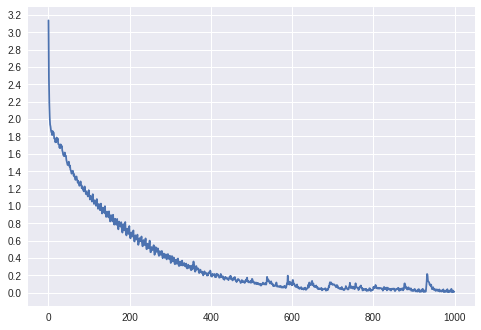

In [45]:
showPlot(plot_losses)